# Comparing importance scores with metrics like correlation & JSD

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm

import sys
sys.path.append('/home/katie/bp_repo/multitask_profile_model_SPI_GATA/')
from plotting_helper import *
from all_functions import *
from profile_models import ModelLoader
import profile_performance
from profile_performance import *

tqdm.tqdm_notebook()

plt.rcParams["figure.dpi"] = 130

/tmp/ipykernel_114815/982504472.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

## Create importance scores dicts if needed ( IN PROGRESS aka how tf do i do this send help )

In [ ]:
# load in importance scores
path = '/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/'

scores_dict = {}

# use same keys as above, but need to specify file paths
paths = ['ctcf_pipeline_mar22/chip_model_chip_shared_peaks',
 'ctcf_pipeline_mar22/cut_model_chip_shared_peaks',
 'ctcf_pipeline_mar22/chip_model_cut_shared_peaks',
 'ctcf_pipeline_mar22/cut_model_cut_shared_peaks',
 'ctcf_pipeline_mar22/chip_model_chip_unique_peaks',
 'ctcf_pipeline_mar22/cut_model_chip_unique_peaks',
 'ctcf_pipeline_mar22/chip_model_cut_unique_peaks',
 'ctcf_pipeline_mar22/cut_model_cut_unique_peaks',
 'fosl2_pipeline_mar22/chip_model_chip_shared_peaks',
 'fosl2_pipeline_mar22/cut_model_chip_shared_peaks',
 'fosl2_pipeline_mar22/chip_model_cut_shared_peaks',
 'fosl2_pipeline_mar22/cut_model_cut_shared_peaks',
 'fosl2_pipeline_mar22/chip_model_chip_unique_peaks',
 'fosl2_pipeline_mar22/cut_model_chip_unique_peaks',
 'fosl2_pipeline_mar22/chip_model_cut_unique_peaks',
 'fosl2_pipeline_mar22/cut_model_cut_unique_peaks']

# actual importance scores loading (like 2 mins, so i just pickled it)
for i in range(len(keys)):
    scores_dict[keys[i]] = import_shap_scores(f'{path}{paths[i]}/shap_scores', hyp_score_key = "hyp_scores", center_cut_size = 400, 
                                    remove_non_acgt=False)[1]  # [1] is for actual scores = hyp_scores * one_hot_seqs 
    
# # hypothetical importance scores loading (like 2 mins, so i just pickled it)
# for i in range(len(keys)):
#     scores_dict[keys[i]] = import_shap_scores(f'{path}{paths[i]}/shap_scores', hyp_score_key = "hyp_scores", center_cut_size = 400, 
#                                     remove_non_acgt=False)[0]  # [0] is for hyp scores

# n.b. i confirmed that the coords loaded in here are identical to the coords in preds_dict, so i decided not to load them in again here

# index scores to unique peaks (without reverse complements)
for key in keys:
    scores_dict[key] = scores_dict[key][preds_dict[key]['indexes_unique']]
    
# dump! change below to act or hyp as needed AND CHANGE DATE TO CORRECT ONE
# import pickle
pickle.dump(scores_dict, 
    open('/home/katie/bp_repo/reports/katie_notebooks/summer2022_analysis/imp_scores_dicts/jul9/act_scores.dict', 'wb'))

## Load in importance scores and set variables

In [2]:
# load in importance scores
act_scores = pickle.load(open('/home/katie/bp_repo/reports/katie_notebooks/summer2022_analysis/act_scores.dict', 'rb'))
hyp_scores = pickle.load(open('/home/katie/bp_repo/reports/katie_notebooks/summer2022_analysis/hyp_scores.dict', 'rb'))

In [3]:
keys = list(act_scores.keys())
key_pairs = [ ('CTCF_chip_model_shared_chip_loader_fake_controls', 'CTCF_cut_model_shared_chip_loader'),
              ('CTCF_chip_model_shared_cut_loader_fake_controls', 'CTCF_cut_model_shared_cut_loader'),
              ('CTCF_chip_model_unique_chip_loader_fake_controls', 'CTCF_cut_model_unique_chip_loader'),
              ('CTCF_chip_model_unique_cut_loader_fake_controls', 'CTCF_cut_model_unique_cut_loader'),
              ('FOSL2_chip_model_shared_chip_loader_fake_controls', 'FOSL2_cut_model_shared_chip_loader'),
              ('FOSL2_chip_model_shared_cut_loader_fake_controls', 'FOSL2_cut_model_shared_cut_loader'),
              ('FOSL2_chip_model_unique_chip_loader_fake_controls', 'FOSL2_cut_model_unique_chip_loader'),
              ('FOSL2_chip_model_unique_cut_loader_fake_controls', 'FOSL2_cut_model_unique_cut_loader')]

In [4]:
subsets = ['CTCF shared ChIP-seq peaks', 'CTCF shared CUT&RUN peaks', 'CTCF unique ChIP-seq peaks', 'CTCF unique CUT&RUN peaks',
           'FOSL2 shared ChIP-seq peaks', 'FOSL2 shared CUT&RUN peaks', 'FOSL2 unique ChIP-seq peaks', 'FOSL2 unique CUT&RUN peaks']
metrics = ['Pearson on act scores', 'Pearson on act scores (CDF)', 'JSD on act scores', 'Continuous Jaccard similarity on hyp scores', 
           'Continuous Jaccard similarity on hyp scores (CDF)', 'Pearson on hyp scores', 'Pearson on hyp scores (CDF)', 'JSD on hyp scores']
means = pd.DataFrame(columns=list('Mean ' + i for i in metrics if i not in ['Pearson on act scores (CDF)',
                      'Continuous Jaccard similarity on hyp scores (CDF)', 'Pearson on hyp scores (CDF)']), index=subsets)

colors = ['darkorange', 'firebrick', 'aqua', 'blue']

## Pearson on *actual* importance scores

In [5]:
# actual scores have 3 0's and 1 non-zero value for each base position, so we sum across this axis to 
# just keep that single non-zero value
for key in keys:
    act_scores[key] = np.sum(act_scores[key], axis=2)  

In [6]:
# now we run the pearson_corr function, which computes correlation across this last dimension
pearson_act_scores = {}
for key in key_pairs:
    pearson_act_scores[key] = pearson_corr(act_scores[key[0]], act_scores[key[1]])

Text(0.5, 1.0, 'Pearson on act scores')

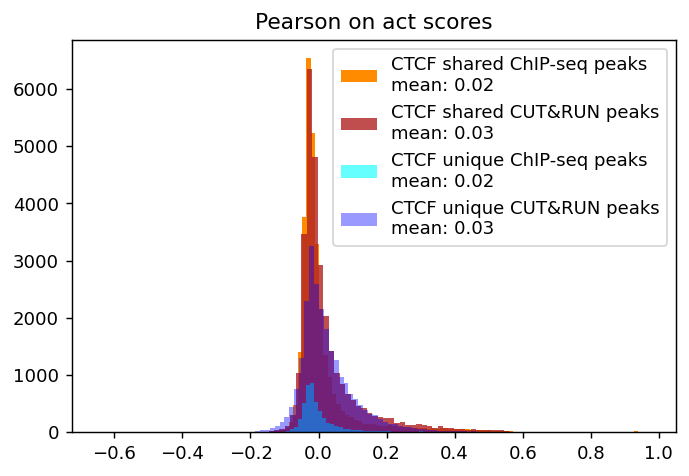

In [7]:
# plot distribution of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(4):
    mean = np.round(np.mean(pearson_act_scores[key_pairs[i]]), 2)
    plt.hist(pearson_act_scores[key_pairs[i]], bins=100, alpha=1-0.2*i, label=f'{subsets[i]}\nmean: {mean}',
            color=colors[i])
    means.loc[subsets[i], 'Mean Pearson on act scores'] = mean
plt.legend()
plt.title(metrics[0])

Text(0.5, 1.0, 'Pearson on act scores (CDF)')

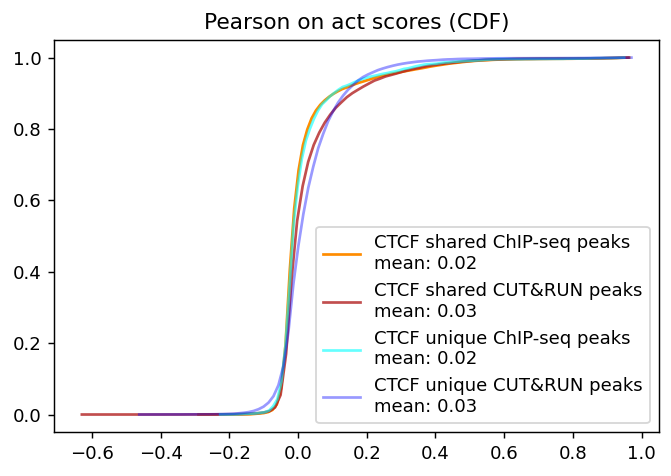

In [8]:
# plot cumulative distribution (CDF) of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(4):
    mean = np.round(np.mean(pearson_act_scores[key_pairs[i]]), 2)
    count, bins_count = np.histogram(pearson_act_scores[key_pairs[i]], bins=100)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, alpha=1-0.20*i, label=f'{subsets[i]}\nmean: {mean}', color=colors[i])
plt.legend()
plt.title(metrics[1])

Text(0.5, 1.0, 'Pearson on act scores')

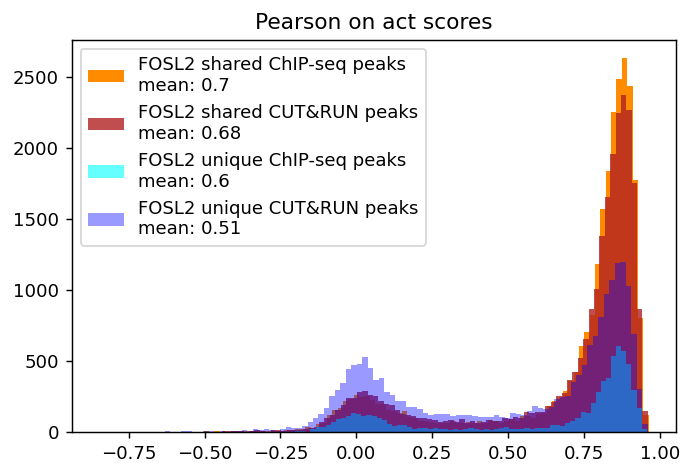

In [9]:
# plot distribution of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(pearson_act_scores[key_pairs[i]]), 2)
    plt.hist(pearson_act_scores[key_pairs[i]], bins=100, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}',
            color=colors[i%4])
    means.loc[subsets[i], 'Mean Pearson on act scores'] = mean
plt.legend()
plt.title(metrics[0])

Text(0.5, 1.0, 'Pearson on act scores (CDF)')

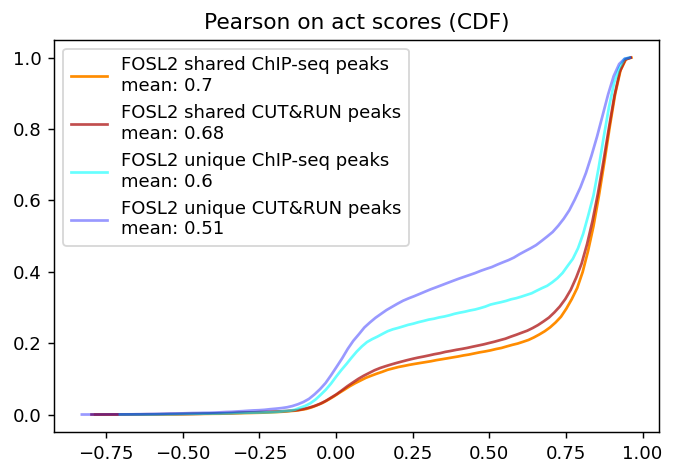

In [10]:
# plot cumulative distribution (CDF) of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(pearson_act_scores[key_pairs[i]]), 2)
    count, bins_count = np.histogram(pearson_act_scores[key_pairs[i]], bins=100)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}', color=colors[i%4])
plt.legend()
plt.title(metrics[1])

## JSD on *actual* importance scores

In [11]:
# now we run the jensen_shannon_distance function, which computes JSD across this last dimension
# n.b. we must take the absolute value of everything before computing JSD!!
jsd_act_scores = {}
for key in key_pairs:
    jsd_act_scores[key] = jensen_shannon_distance(np.abs(act_scores[key[0]]), np.abs(act_scores[key[1]]))

Text(0.5, 1.0, 'JSD on act scores')

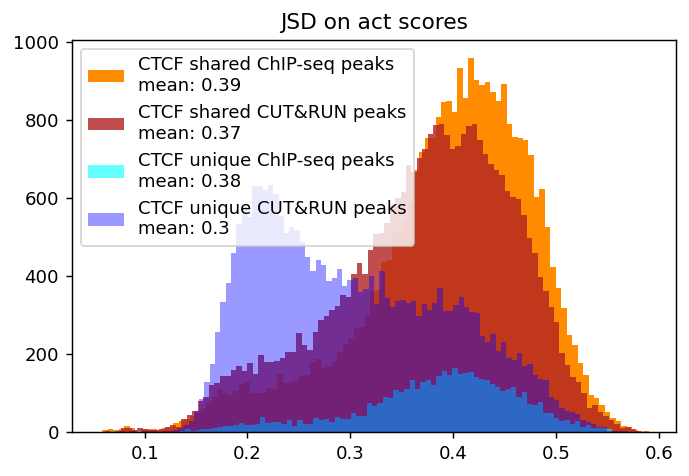

In [12]:
# plot distribution of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(4):
    mean = np.round(np.mean(jsd_act_scores[key_pairs[i]]), 2)
    plt.hist(jsd_act_scores[key_pairs[i]], bins=100, alpha=1-0.2*i, label=f'{subsets[i]}\nmean: {mean}',
            color=colors[i])
    means.loc[subsets[i], 'Mean JSD on act scores'] = mean
plt.legend()
plt.title(metrics[2])

Text(0.5, 1.0, 'JSD on act scores')

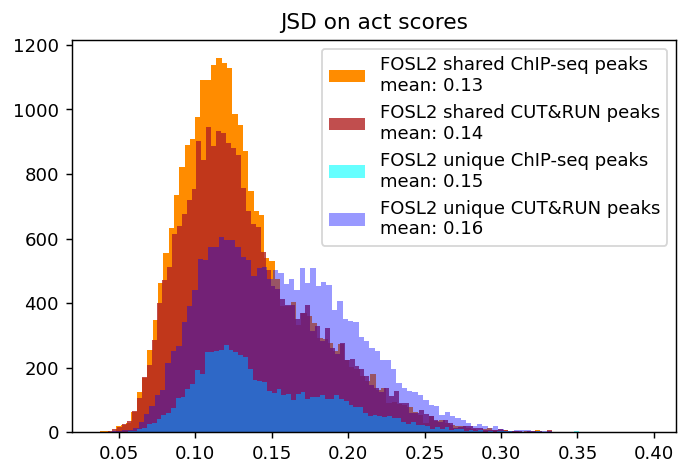

In [13]:
# plot distribution of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(jsd_act_scores[key_pairs[i]]), 2)
    plt.hist(jsd_act_scores[key_pairs[i]], bins=100, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}',
            color=colors[i%4])
    means.loc[subsets[i], 'Mean JSD on act scores'] = mean
plt.legend()
plt.title(metrics[2])

## Continuous jaccard similarity on *hypothetical* importance scores

In [14]:
def cont_jaccard(seq_1, seq_2):
    """
    Takes two gradient sequences (I x 4 arrays) and computes a similarity between
    them, using a continuous Jaccard metric.
    """
    # L1-normalize
    norm_1 = np.sum(np.abs(seq_1), axis=1, keepdims=True)
    norm_2 = np.sum(np.abs(seq_2), axis=1, keepdims=True)
    norm_1[norm_1 == 0] = 1
    norm_2[norm_2 == 0] = 1
    seq_1 = seq_1 / norm_1
    seq_2 = seq_2 / norm_2
    
    ab_1, ab_2 = np.abs(seq_1), np.abs(seq_2)
    inter = np.sum(np.minimum(ab_1, ab_2) * np.sign(seq_1) * np.sign(seq_2), axis=1)
    union = np.sum(np.maximum(ab_1, ab_2), axis=1)
    zero_mask = union == 0
    inter[zero_mask] = 0
    union[zero_mask] = 1
    return np.sum(inter / union)

In [15]:
jaccard_hyp_scores = {}
for key in key_pairs:
    jaccard_hyp_scores[key] = list(cont_jaccard( hyp_scores[key[0]][i], hyp_scores[key[1]][i] ) for i in range(len(hyp_scores[key[0]])))

Text(0.5, 1.0, 'Continuous Jaccard similarity on hyp scores')

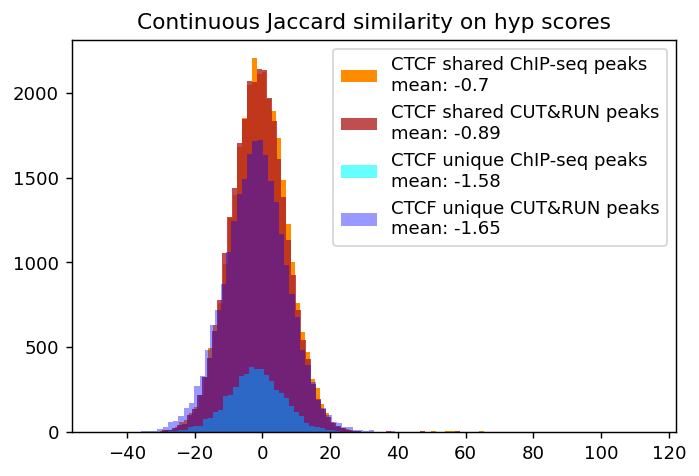

In [16]:
# plot distribution of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(4):
    mean = np.round(np.mean(jaccard_hyp_scores[key_pairs[i]]), 2)
    plt.hist(jaccard_hyp_scores[key_pairs[i]], bins=100, alpha=1-0.2*i, label=f'{subsets[i]}\nmean: {mean}',
            color=colors[i])
    means.loc[subsets[i], 'Mean Continuous Jaccard similarity on hyp scores'] = mean
plt.legend()
plt.title(metrics[3])

Text(0.5, 1.0, 'Continuous Jaccard similarity on hyp scores (CDF)')

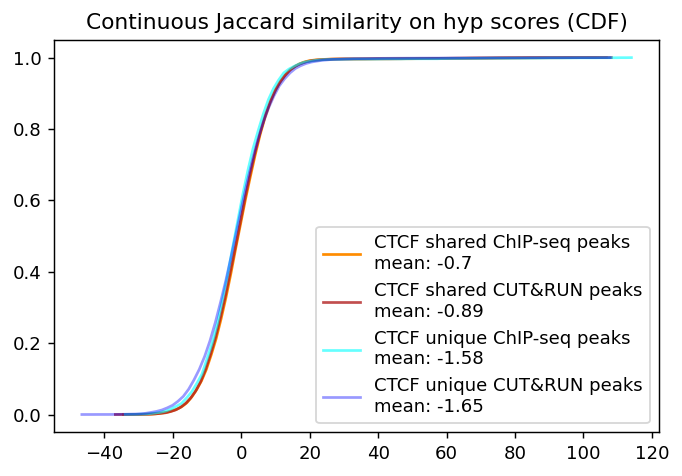

In [17]:
# plot cumulative distribution (CDF) of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(0,4):
    mean = np.round(np.mean(jaccard_hyp_scores[key_pairs[i]]), 2)
    count, bins_count = np.histogram(jaccard_hyp_scores[key_pairs[i]], bins=100)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, alpha=1-0.2*i, label=f'{subsets[i]}\nmean: {mean}', color=colors[i%4])
plt.legend()
plt.title(metrics[4])

Text(0.5, 1.0, 'Continuous Jaccard similarity on hyp scores')

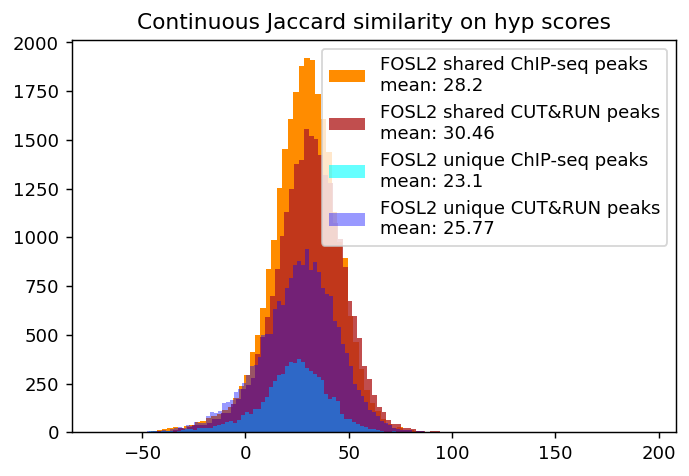

In [18]:
# plot distribution of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(jaccard_hyp_scores[key_pairs[i]]), 2)
    plt.hist(jaccard_hyp_scores[key_pairs[i]], bins=100, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}',
            color=colors[i%4])
    means.loc[subsets[i], 'Mean Continuous Jaccard similarity on hyp scores'] = mean
plt.legend()
plt.title(metrics[3])

Text(0.5, 1.0, 'Continuous Jaccard similarity on hyp scores (CDF)')

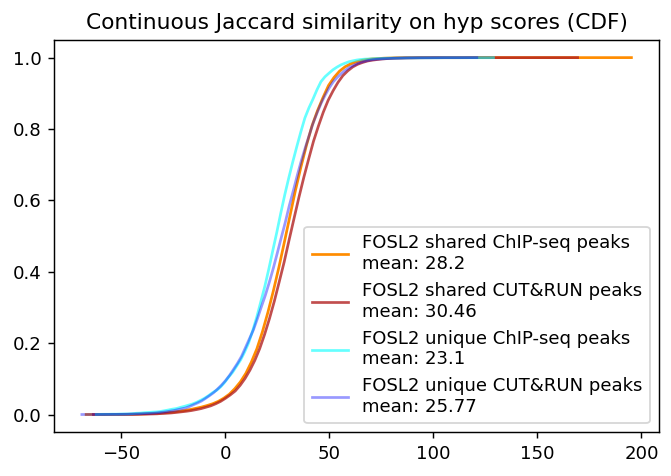

In [19]:
# plot cumulative distribution (CDF) of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(jaccard_hyp_scores[key_pairs[i]]), 2)
    count, bins_count = np.histogram(jaccard_hyp_scores[key_pairs[i]], bins=100)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}', color=colors[i%4])
plt.legend()
plt.title(metrics[4])

## Pearson on *hypothetical* importance scores

In [20]:
# to do stuff on hyp scores, we need to flatten the last two dimensions (400 x 4) into one dimension (1600)
for key in keys:
    hyp_scores[key] = hyp_scores[key].reshape((-1, 1600))

In [21]:
# now we run the pearson_corr function, which computes correlation across this last dimension
pearson_hyp_scores = {}
for key in key_pairs:
    pearson_hyp_scores[key] = pearson_corr(hyp_scores[key[0]], hyp_scores[key[1]])

Text(0.5, 1.0, 'Pearson on hyp scores')

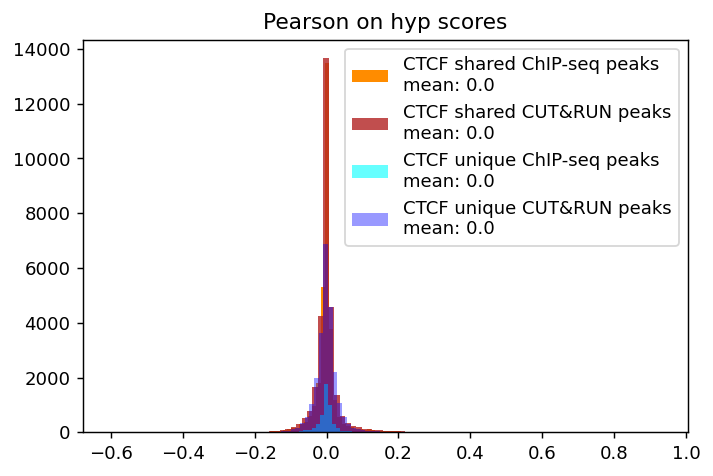

In [22]:
# plot distribution of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(4):
    mean = np.round(np.mean(pearson_hyp_scores[key_pairs[i]]), 2)
    plt.hist(pearson_hyp_scores[key_pairs[i]], bins=100, alpha=1-0.2*i, label=f'{subsets[i]}\nmean: {mean}',
            color=colors[i])
    means.loc[subsets[i], 'Mean Pearson on hyp scores'] = mean
plt.legend()
plt.title(metrics[5])

Text(0.5, 1.0, 'Pearson on hyp scores (CDF)')

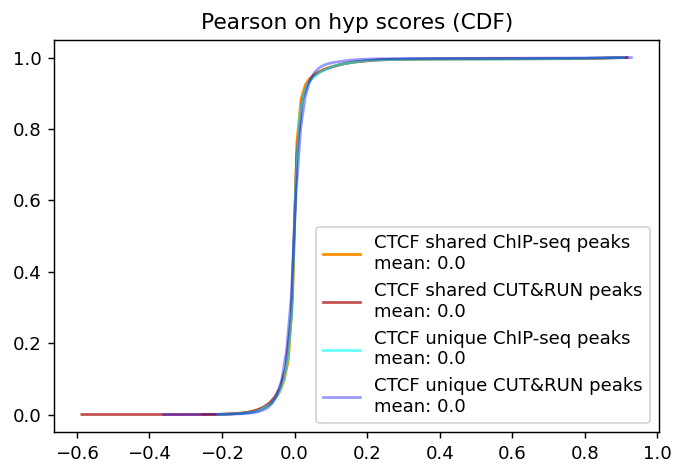

In [23]:
# plot cumulative distribution (CDF) of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(4):
    mean = np.round(np.mean(pearson_hyp_scores[key_pairs[i]]), 2)
    count, bins_count = np.histogram(pearson_hyp_scores[key_pairs[i]], bins=100)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, alpha=1-0.2*i, label=f'{subsets[i]}\nmean: {mean}', color=colors[i])
plt.legend()
plt.title(metrics[6])

Text(0.5, 1.0, 'Pearson on hyp scores')

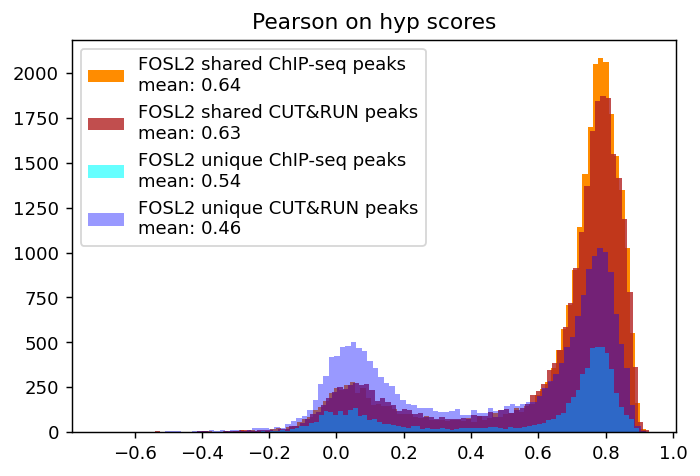

In [24]:
# plot distribution of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(pearson_hyp_scores[key_pairs[i]]), 2)
    plt.hist(pearson_hyp_scores[key_pairs[i]], bins=100, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}',
            color=colors[i%4])
    means.loc[subsets[i], 'Mean Pearson on hyp scores'] = mean
plt.legend()
plt.title(metrics[5])

Text(0.5, 1.0, 'Pearson on hyp scores (CDF)')

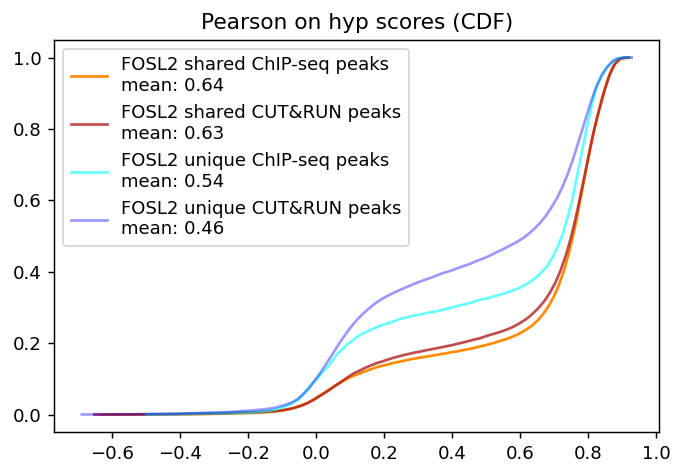

In [25]:
# plot cumulative distribution (CDF) of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(pearson_hyp_scores[key_pairs[i]]), 2)
    count, bins_count = np.histogram(pearson_hyp_scores[key_pairs[i]], bins=100)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}', color=colors[i%4])
plt.legend()
plt.title(metrics[6])

## JSD on *hypothetical* importance scores

In [26]:
# now we run the jensen_shannon_distance function, which computes JSD across this last dimension
# n.b. we must take the absolute value of everything before computing JSD!!
jsd_hyp_scores = {}
for key in key_pairs:
    jsd_hyp_scores[key] = jensen_shannon_distance(np.abs(hyp_scores[key[0]]), np.abs(hyp_scores[key[1]]))

Text(0.5, 1.0, 'JSD on hyp scores')

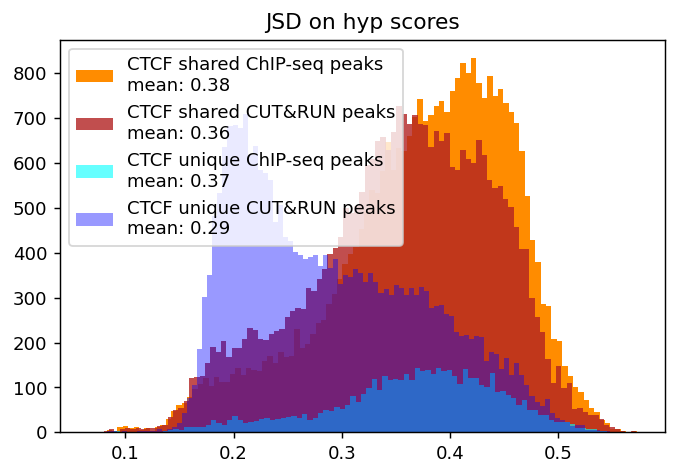

In [27]:
# plot distribution of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(4):
    mean = np.round(np.mean(jsd_hyp_scores[key_pairs[i]]), 2)
    plt.hist(jsd_hyp_scores[key_pairs[i]], bins=100, alpha=1-0.2*i, label=f'{subsets[i]}\nmean: {mean}',
            color=colors[i])
    means.loc[subsets[i], 'Mean JSD on hyp scores'] = mean
plt.legend()
plt.title(metrics[7])

Text(0.5, 1.0, 'JSD on hyp scores')

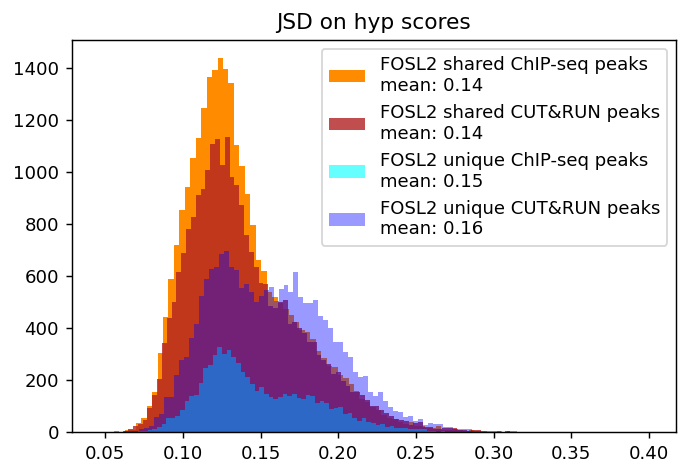

In [28]:
# plot distribution of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(jsd_hyp_scores[key_pairs[i]]), 2)
    plt.hist(jsd_hyp_scores[key_pairs[i]], bins=100, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}',
            color=colors[i%4])
    means.loc[subsets[i], 'Mean JSD on hyp scores'] = mean
plt.legend()
plt.title(metrics[7])

In [29]:
means

,Mean Pearson on act scores,Mean JSD on act scores,Mean Continuous Jaccard similarity on hyp scores,Mean Pearson on hyp scores,Mean JSD on hyp scores
CTCF shared ChIP-seq peaks,0.02,0.39,-0.7,0.0,0.38
CTCF shared CUT&RUN peaks,0.03,0.37,-0.89,0.0,0.36
CTCF unique ChIP-seq peaks,0.02,0.38,-1.58,0.0,0.37
CTCF unique CUT&RUN peaks,0.03,0.3,-1.65,0.0,0.29
FOSL2 shared ChIP-seq peaks,0.7,0.13,28.2,0.64,0.14
FOSL2 shared CUT&RUN peaks,0.68,0.14,30.46,0.63,0.14
FOSL2 unique ChIP-seq peaks,0.6,0.15,23.1,0.54,0.15
FOSL2 unique CUT&RUN peaks,0.51,0.16,25.77,0.46,0.16


In [64]:
def plot_metrics(tf, metric):
    subsets = ['shared ChIP-seq peaks', 'shared CUT&RUN peaks', 'unique ChIP-seq peaks', 'unique CUT&RUN peaks']
    
    labels = ['Shared ChIP-seq', 'Shared CUT&RUN', 'Unique ChIP-seq', 'Unique CUT&RUN']
    
    rects_values = list(means.loc[f'{tf} {subset}', metric] for subset in subsets)
    
    width = 0.7       # the width of the bars: can also be len(x) sequence
    ind = np.arange(len(labels))

    fig, ax = plt.subplots()

    rects = ax.bar(ind, rects_values, width)

    ax.set_xticks(ind, labels, rotation=30)
    ax.set_xlabel('Peak subset')
    ax.set_ylabel(metric)
    ax.set_title(f"{tf} mean similarity")
    
    ax.bar_label(rects, padding=1, fontsize=8)

    plt.show()

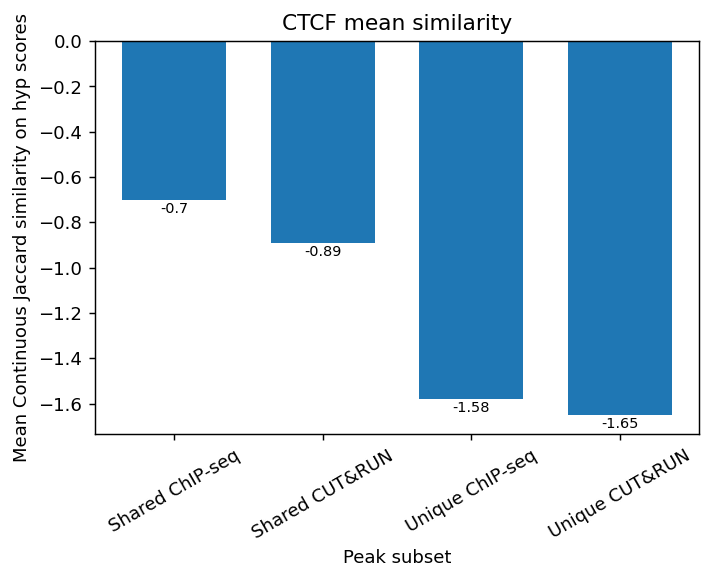

In [68]:
plot_metrics('CTCF', 'Mean Continuous Jaccard similarity on hyp scores')

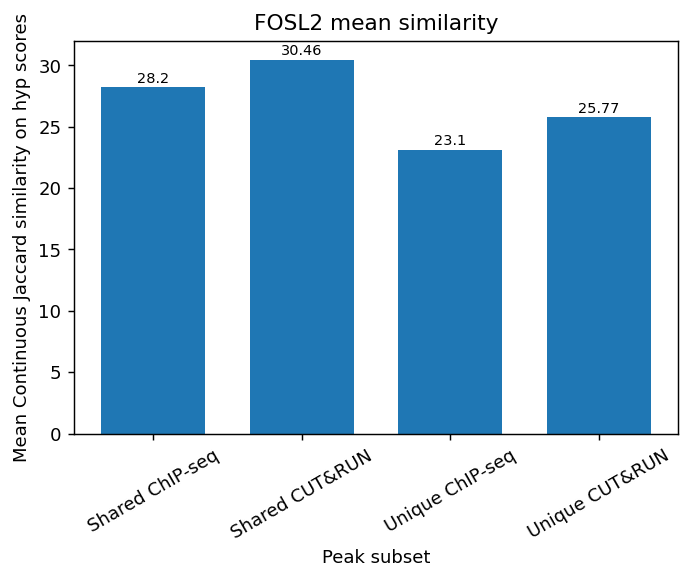

In [69]:
plot_metrics('FOSL2', 'Mean Continuous Jaccard similarity on hyp scores')